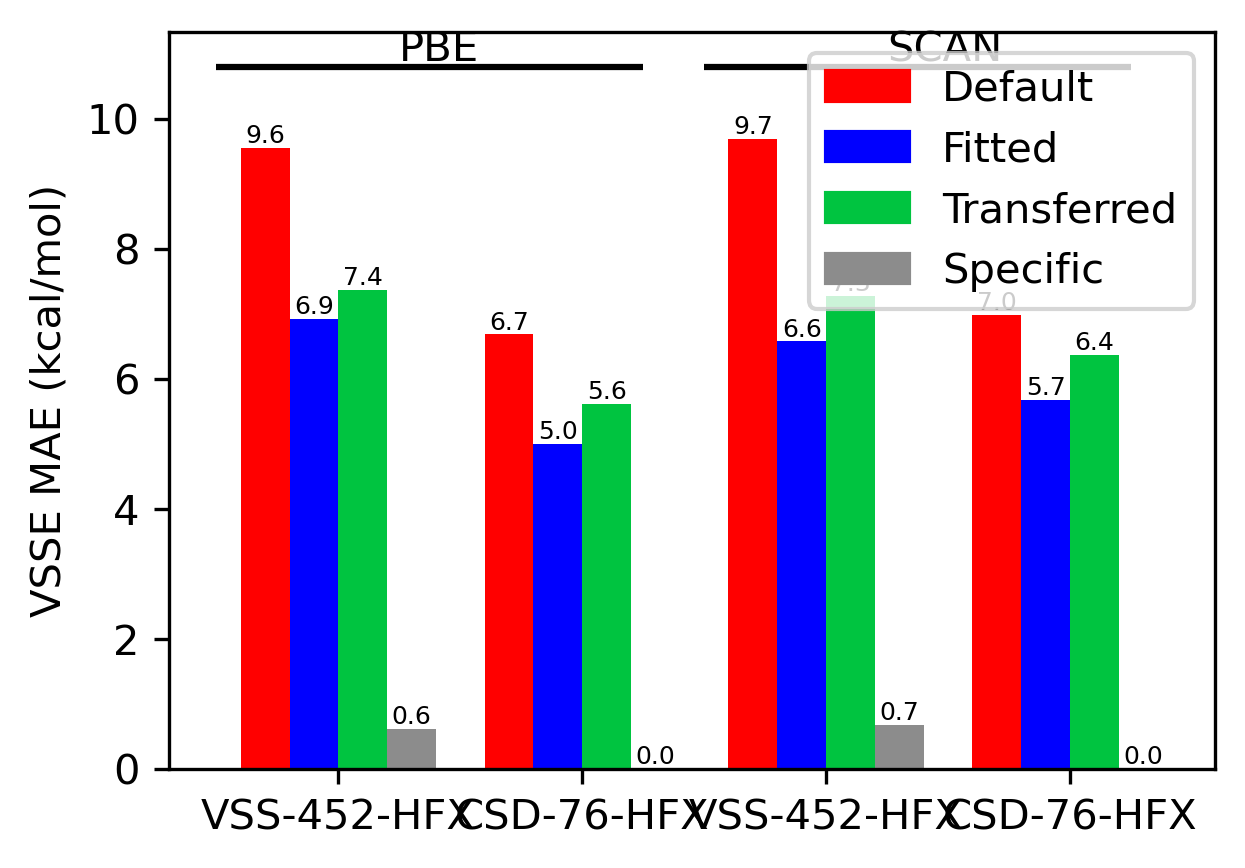

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')

vss_structures = vss_sse_df.index
functionals = vss_sse_df.columns

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')

vss_pbe_sse = vss_sse_df.drop([key for key in vss_sse_df.keys() if 'scan' in key], axis=1)
vss_scan_sse = vss_sse_df.drop([key for key in vss_sse_df.keys() if 'pbe' in key], axis=1)
csd_pbe_sse = csd_sse_df.drop([key for key in csd_sse_df.keys() if 'scan' in key], axis=1)
csd_scan_sse = csd_sse_df.drop([key for key in csd_sse_df.keys() if 'pbe' in key], axis=1)

scan_map = {}
pbe_map = {}
for column in vss_scan_sse.columns:
    scan_map[column] = int(column.split('_')[-1])
for column in vss_pbe_sse.columns:
    pbe_map[column] = int(column.split('_')[-1])

vss_scan_sse = vss_scan_sse.rename(columns=scan_map).sort_index(axis=1)
vss_pbe_sse = vss_pbe_sse.rename(columns=pbe_map).sort_index(axis=1)
csd_scan_sse = csd_scan_sse.rename(columns=scan_map).sort_index(axis=1)
csd_pbe_sse = csd_pbe_sse.rename(columns=pbe_map).sort_index(axis=1)

vss_df = pd.read_csv('../data/VSS-452.csv')
csd_df = pd.read_csv('../data/CSD-76.csv')
to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in row['name']:
        to_remove.append(idx)
csd_df = csd_df.drop(to_remove)

csd_targets = pd.read_csv('../data/CSD76targets.csv')
vss_targets = pd.read_csv('../data/VSS452targets.csv')

functionals = ['pbe', 'scan']

single_hfx_pbe_csd = np.nan
single_hfx_pbe_csd_val = np.nan
single_hfx_scan_csd = np.nan
single_hfx_scan_csd_val = np.nan
single_hfx_pbe_vss = np.nan
single_hfx_pbe_vss_val = np.nan
single_hfx_scan_vss = np.nan
single_hfx_scan_vss_val = np.nan

for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            if base_functional == 'pbe':
                df = csd_pbe_sse
            else:
                df = csd_scan_sse
            reference_df = csd_df
        else:
            if base_functional == 'pbe':
                df = vss_pbe_sse
            else:
                df = vss_scan_sse
            reference_df = vss_df
            
        def objective(optimal_hfx, df, reference_df):
            errors = []
            for _, row in df.iterrows():
                hfx_vals = []
                vsses = []
                optimal_vsse = reference_df.loc[reference_df['name'] == row.name.split('/')[-1]]['dlpno-CCSD_T.vertsse'].item()
                for hfx in row.index:
                    if not np.isnan(row[hfx]):
                        hfx_vals.append(hfx)
                        vsses.append(row[hfx])
                if len(hfx_vals) < 5:
                    continue
                fit = interp1d(hfx_vals, vsses, kind='linear', fill_value='extrapolate')
                errors.append(np.abs(fit(optimal_hfx) - optimal_vsse))
            return np.mean(errors)

        fun = lambda hfx: objective(hfx, df, reference_df)
        res = minimize(fun, 40, method='Nelder-Mead')
        #print(res)
        if idx == 0:
            if base_functional == 'pbe':
                single_hfx_pbe_csd = res.fun
                single_hfx_pbe_csd_val = res.x[0]
            else:
                single_hfx_scan_csd = res.fun
                single_hfx_scan_csd_val = res.x[0]
        else:
            if base_functional == 'pbe':
                single_hfx_pbe_vss = res.fun
                single_hfx_pbe_vss_val = res.x[0]
            else:
                single_hfx_scan_vss = res.fun
                single_hfx_scan_vss_val = res.x[0]

transfer_hfx_pbe_csd = np.nan
transfer_hfx_scan_csd = np.nan
transfer_hfx_pbe_vss = np.nan
transfer_hfx_scan_vss = np.nan

for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            reference_df = csd_df
            if base_functional == 'pbe':
                df = csd_pbe_sse
                transfer_hfx_pbe_csd = objective(single_hfx_pbe_vss_val, df, reference_df)
            else:
                df = csd_scan_sse
                transfer_hfx_scan_csd = objective(single_hfx_scan_vss_val, df, reference_df)
        else:
            reference_df = vss_df
            if base_functional == 'pbe':
                df = vss_pbe_sse
                transfer_hfx_pbe_vss = objective(single_hfx_pbe_csd_val, df, reference_df)
            else:
                df = vss_scan_sse
                transfer_hfx_scan_vss = objective(single_hfx_scan_csd_val, df, reference_df)
            
specific_hfx_pbe_csd = np.nan
specific_hfx_scan_csd = np.nan
specific_hfx_pbe_vss = np.nan
specific_hfx_scan_vss = np.nan

for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            if base_functional == 'pbe':
                df = csd_pbe_sse
            else:
                df = csd_scan_sse
            reference_df = csd_df
        else:
            if base_functional == 'pbe':
                df = vss_pbe_sse
            else:
                df = vss_scan_sse
            reference_df = vss_df
            
        def objective(df, reference_df, target_df):
            errors = []
            total = 0
            num_not_reproduced = 0
            for _, row in df.iterrows():
                hfx_vals = []
                vsses = []
                optimal_vsse = reference_df.loc[reference_df['name'] == row.name.split('/')[-1]]['dlpno-CCSD_T.vertsse'].item()
                for hfx in row.index:
                    if not np.isnan(row[hfx]):
                        hfx_vals.append(hfx)
                        vsses.append(row[hfx])
                if len(hfx_vals) < 5:
                    continue
                total += 1
                fit = interp1d(hfx_vals, vsses, kind='linear', fill_value='extrapolate')

                optimal_hfx = target_df.loc[target_df['Unnamed: 0'] == row.name]['hfx_' + base_functional].item()
                if optimal_hfx > 100 or optimal_hfx < 0:
                    num_not_reproduced += 1
                if optimal_hfx > 100:
                    optimal_hfx = 100
                elif optimal_hfx < 0:
                    optimal_hfx = 0
                errors.append(np.abs(fit(optimal_hfx) - optimal_vsse))
            return np.mean(errors), num_not_reproduced, total-num_not_reproduced, (total-num_not_reproduced)/total

        #print(base_functional, idx, objective(df, reference_df, target_df))
        
        if idx == 0:
            if base_functional == 'pbe':
                specific_hfx_pbe_csd = objective(df, reference_df, target_df)[0]
            else:
                specific_hfx_scan_csd = objective(df, reference_df, target_df)[0]
        else:
            if base_functional == 'pbe':
                specific_hfx_pbe_vss = objective(df, reference_df, target_df)[0]
            else:
                specific_hfx_scan_vss = objective(df, reference_df, target_df)[0]

vss_df = vss_df.set_index(vss_df['name'])
csd_df = csd_df.set_index(csd_df['name'])

pbe_csd_err = []
pbe0_csd_err = []
for idx, row in csd_pbe_sse.iterrows():
    if not np.isnan(row[0]):
        pbe_csd_err.append(row[0] - csd_df.loc[idx]['dlpno-CCSD_T.vertsse'])
    if not np.isnan(row[25]):
        pbe0_csd_err.append(row[25] - csd_df.loc[idx]['dlpno-CCSD_T.vertsse'])

csd_pbe_vals = [np.abs(pbe_csd_err).mean(), np.abs(pbe0_csd_err).mean(), single_hfx_pbe_csd, specific_hfx_pbe_csd]

scan_csd_err = []
scan0_csd_err = []
for idx, row in csd_scan_sse.iterrows():
    if not np.isnan(row[0]):
        scan_csd_err.append(row[0] - csd_df.loc[idx]['dlpno-CCSD_T.vertsse'])
    if not np.isnan(row[25]):
        scan0_csd_err.append(row[25] - csd_df.loc[idx]['dlpno-CCSD_T.vertsse'])

csd_scan_vals = [np.abs(scan_csd_err).mean(), np.abs(scan0_csd_err).mean(), single_hfx_scan_csd, specific_hfx_scan_csd]


pbe_vss_err = []
pbe0_vss_err = []
for idx, row in vss_pbe_sse.iterrows():
    if not np.isnan(row[0]):
        pbe_vss_err.append(row[0] - vss_df.loc[idx.split('/')[-1]]['dlpno-CCSD_T.vertsse'])
    if not np.isnan(row[25]):
        pbe0_vss_err.append(row[25] - vss_df.loc[idx.split('/')[-1]]['dlpno-CCSD_T.vertsse'])

vss_pbe_vals = [np.abs(pbe_vss_err).mean(), np.abs(pbe0_vss_err).mean(), single_hfx_pbe_vss, specific_hfx_pbe_vss]

scan_vss_err = []
scan0_vss_err = []
for idx, row in vss_scan_sse.iterrows():
    if not np.isnan(row[0]):
        scan_vss_err.append(row[0] - vss_df.loc[idx.split('/')[-1]]['dlpno-CCSD_T.vertsse'])
    if not np.isnan(row[25]):
        scan0_vss_err.append(row[25] - vss_df.loc[idx.split('/')[-1]]['dlpno-CCSD_T.vertsse'])

vss_scan_vals = [np.abs(scan_vss_err).mean(), np.abs(scan0_vss_err).mean(), single_hfx_scan_vss, specific_hfx_scan_vss]

colors = ['#FF0000', '#0000FF', '#00C440', '#8c8c8c']
sizes = np.arange(4)

for i in range(5):
    if i == 0:
        base_errs = (vss_pbe_vals[i], csd_pbe_vals[i], vss_scan_vals[i], csd_scan_vals[i])
    elif i == 1:
        hybrid_errs = (vss_pbe_vals[i], csd_pbe_vals[i], vss_scan_vals[i], csd_scan_vals[i])
    elif i == 2:
        single_hfx_errs = (vss_pbe_vals[i], csd_pbe_vals[i], vss_scan_vals[i], csd_scan_vals[i])
    elif i ==3:
        specific_hfx_errs = (vss_pbe_vals[i], csd_pbe_vals[i], vss_scan_vals[i], csd_scan_vals[i])
    else:
        transfer_hfx_errs = (transfer_hfx_pbe_vss, transfer_hfx_pbe_csd, transfer_hfx_scan_vss, transfer_hfx_scan_csd)

fig, ax = plt.subplots(figsize=(4.25, 3.0), dpi=300)
ax.bar(sizes-0.3, hybrid_errs, 0.2, color=colors[0])
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes-0.1, single_hfx_errs, 0.2, color=colors[1])
ax.bar_label(ax.containers[1], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.1, transfer_hfx_errs, 0.2, color=colors[2])
ax.bar_label(ax.containers[2], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.3, specific_hfx_errs, 0.2, color=colors[3])
ax.bar_label(ax.containers[3], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.set_xticks(np.arange(4), ['VSS-452-HFX', 'CSD-76-HFX', 'VSS-452-HFX', 'CSD-76-HFX'])
ax.set_ylabel('VSSE MAE (kcal/mol)')

import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#FF0000', label='Default')
patch1 = mpatches.Patch(color='#0000FF', label='Fitted')
patch2 = mpatches.Patch(color='#00C440', label='Transferred')
patch3 = mpatches.Patch(color='#8c8c8c', label='Specific')
ax.legend(handles=[patch0, patch1, patch2, patch3])

ax.text(0.25, 10.9, 'PBE')
ax.text(2.25, 10.9, 'SCAN')
ax.hlines(10.8, xmin=-0.5, xmax=1.25, color='black')
ax.hlines(10.8, xmin=1.5, xmax=3.25, color='black')
fig.tight_layout()

In [2]:
specific_hfx_errs

(0.6169181057421301,
 1.4667792311899273e-05,
 0.6802853729358146,
 1.4787346110771405e-05)